# Imports

In [1]:
import time
start_time = time.time()

In [2]:
import sys
sys.path.append('..')

from main_functions import *

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

# Simulate spatial data

In [4]:
# Simulation of random cluster of points. Origin points (parents) generated as homogeneous Poisson process (totally random) with mean `mu`.
# Each origin generates on average `alpha` additional points (children) randomly distributed in a circle of radius `r` around it.
def sim_spatial_1gen(mu, alpha, r, horizon_x, horizon_y, seed=0):
    rd_idx = seed
    np.random.seed(rd_idx)

    N_0 = np.random.poisson(mu*(horizon_x * horizon_y))
    T_0 = np.vstack((np.random.uniform(0, horizon_x, size=(1, N_0)), np.random.uniform(0, horizon_y, size=(1, N_0))))
    aux = np.argsort(T_0[0,:])
    T_0 = T_0[:, aux]
    
    gen = 0

    points = T_0.copy() 
    
    N_parents = N_0
    N_tot = N_0
    
    T_parents = [(t, z) for z, t in enumerate(T_0.T)]

    while N_parents > 0:
        N_parents = 0
        gen += 1
        T_offspring = []
        
        for i, (t, z) in enumerate(T_parents):
            N_aux = np.random.poisson(alpha)
            
            theta = np.random.uniform(0, 2*np.pi, N_aux)
            children = np.array([r * np.cos(theta), r * np.sin(theta)])
            
            T_aux = t.reshape(2,1) + children
    
            aux = (0<= T_aux[0, :]) * (T_aux[0, :] <= horizon_x) * (0<= T_aux[1, :]) * (T_aux[1, :] <= horizon_y)
            T_aux = T_aux[:, aux]
    
            N_aux = T_aux.shape[1]
    
            T_offspring += [(t_aux, z) for t_aux in T_aux.T]

            points = np.hstack((points, T_aux))
            
        T_parents = T_offspring
        #T_0 += T_1

    return points

Must show dataframe with 158 rows and 3 columns: 
             X          Y     marks
0     0.375796   0.783756  0.959167
1     0.404368   5.065832  0.458139
2     1.420721   3.226190  0.590984
3     1.742586  13.062167  0.857723
4     2.365489   7.374503  0.457223
..         ...        ...       ...
153  18.961981   6.323895  0.024313
154  18.804102   8.157332  0.342611
155  19.315834   6.275122  0.622231
156  18.616959   6.519712  0.279068
157  19.859743   1.249685  0.209750

[158 rows x 3 columns]
[0.37579601 0.40436795 1.42072116 1.74258599 2.36548852 2.86706575
 5.29111224 7.19015801 7.66883038 8.2932388 ]


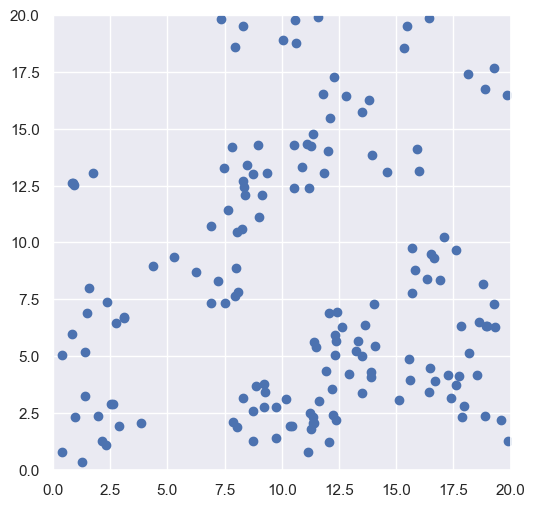

In [5]:
# Example of point process. Note that each vector of coordinates can be one-dimensional or two-dimensional as auxiliary function in code will make all code work in both cases.
horizon_x, horizon_y = 20.0, 20.0

# Change random_seed for different results. All reported results in markdown are done for random_seed = 0.
random_seed = 0
X, Y = sim_spatial_1gen(0.1, 3, 1.0, horizon_x, horizon_y, seed=random_seed)
# Create completely random (iid) marks from a uniform distribution.
marks = np.random.uniform(0, 1, len(X))

# Creation of .xlsx for example of reading data with pandas dataframe (as with real data from paper).
df = pd.DataFrame({"X":X, "Y":Y, "marks":marks})
df.to_excel("demo.xlsx", index=False)  

fig, ax = plt.subplots(figsize=(5.90666 * 1, 5.90666 * 1))
ax.scatter(X, Y)
ax.set_xlim((0.0, horizon_x))
ax.set_ylim((0.0, horizon_y))

print("Must show dataframe with 158 rows and 3 columns: ")
print(df)
print(X[0:10])

In [6]:
# Example of reading data from xlsx (or other using pandas package). Recommended to transform all vectors to numpy arrays.
df = pd.read_excel('demo.xlsx', index_col=None)#, index_col=None, header=None)  
X, Y, marks = df["X"].to_numpy(), df["Y"].to_numpy(), df["marks"].to_numpy()
print(X[0:10])
print(df)

[0.37579601 0.40436795 1.42072116 1.74258599 2.36548852 2.86706575
 5.29111224 7.19015801 7.66883038 8.2932388 ]
             X          Y     marks
0     0.375796   0.783756  0.959167
1     0.404368   5.065832  0.458139
2     1.420721   3.226190  0.590984
3     1.742586  13.062167  0.857723
4     2.365489   7.374503  0.457223
..         ...        ...       ...
153  18.961981   6.323895  0.024313
154  18.804102   8.157332  0.342611
155  19.315834   6.275122  0.622231
156  18.616959   6.519712  0.279068
157  19.859743   1.249685  0.209750

[158 rows x 3 columns]


# Estimating spatial and marked K functions

Expected result: estimated curves must be above the references (clustering), with a jump at r=1, radius at which children were generated. 


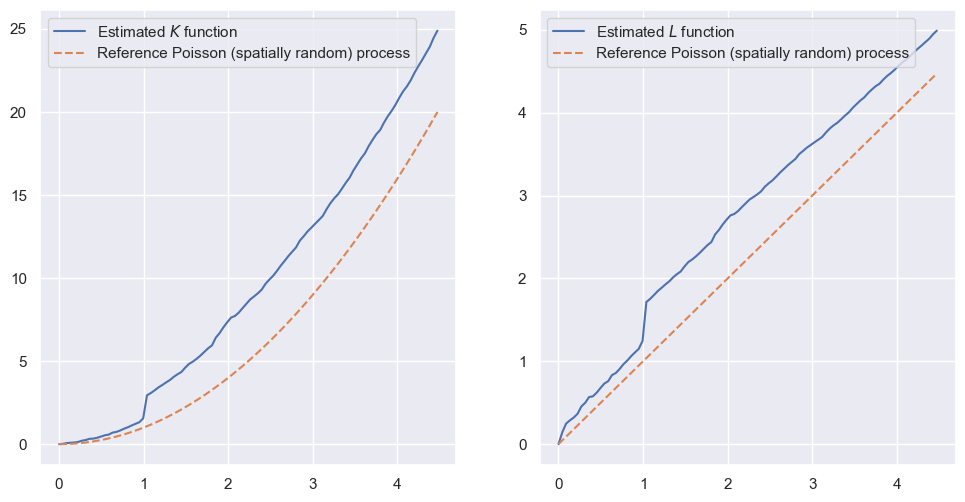

In [7]:
# Define radius list.
r_list = np.linspace(0, np.sqrt(horizon_x), 100)
K_func, sq_mean_intensity = spatial_K_func(X, Y, r_list, horizon_x, horizon_y)

# Plot normalised spatial K function and L function and references to spatially random process.
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5.90666 * 2, 5.90666 * 1))
ax.plot(r_list, K_func / (np.pi * sq_mean_intensity), label="Estimated $K$ function")
ax.plot(r_list, (r_list ** 2), linestyle="--", label="Reference Poisson (spatially random) process")

ax2.plot(r_list, np.sqrt(K_func / (np.pi * sq_mean_intensity)), label="Estimated $L$ function")
ax2.plot(r_list, r_list, linestyle="--", label="Reference Poisson (spatially random) process")

ax.legend()
ax2.legend()

print("Expected result: estimated curves must be above the references (clustering), with a jump at r=1, radius at which children were generated. ")

In [8]:
# Example of marked K functions with classic marked interaction function. These functions do not need any particular values for lower_bound and upper_bound so can be put at any arbitrary float value.
# This includes m_multiplicative_func, m_r_func, m_r2_func, m_variogram_func

mK_func1, mean_mark1 = marked_K_func(X, Y, r_list, horizon_x, horizon_y, 0.0, 0.0, marks, marks, m_multiplicative_func)
mK_func2, mean_mark2 = marked_K_func(X, Y, r_list, horizon_x, horizon_y, 0.0, 0.0, marks, marks, m_variogram_func)

Expected result: By plotting side by side marked and spatial K functions, as marks are completely random and independent from the spatial process, both curves are seemingly identical, as proof of this.


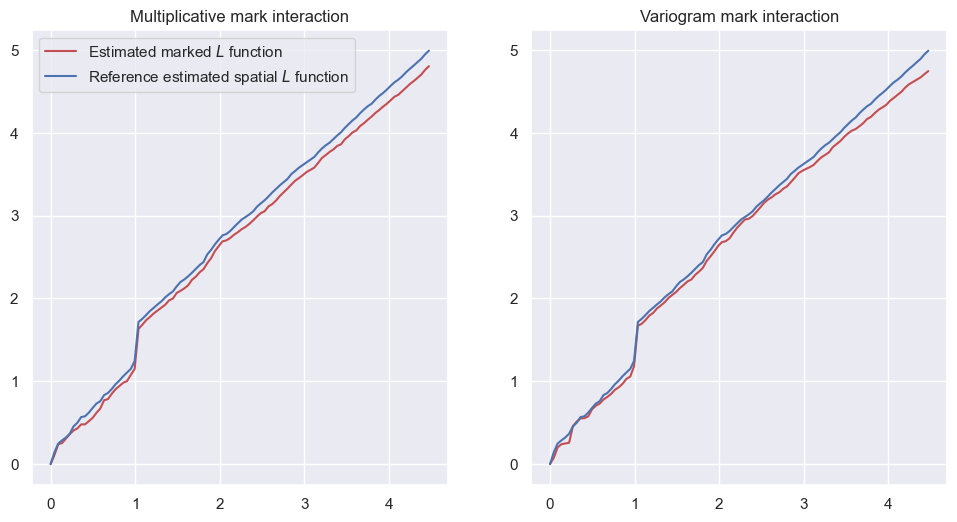

In [9]:
# Plot marked L functions
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5.90666 * 2, 5.90666 * 1))
ax.plot(r_list, np.sqrt(mK_func1 / (np.pi * mean_mark1 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax.plot(r_list, np.sqrt(K_func / (np.pi * sq_mean_intensity)), label="Reference estimated spatial $L$ function")
ax.set_title("Multiplicative mark interaction")

ax2.plot(r_list, np.sqrt(mK_func2 / (np.pi * mean_mark2 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax2.plot(r_list, np.sqrt(K_func / (np.pi * sq_mean_intensity)), label="Reference estimated spatial $L$ function")
ax2.set_title("Variogram mark interaction")

ax.legend()
print("Expected result: By plotting side by side marked and spatial K functions, as marks are completely random and independent from the spatial process, both curves are seemingly identical, as proof of this.")

# Marked functions by categories and testing

In [10]:
# Lower and upper bound are only used in functions `m_func_inf`, `m_func_mid`, `m_func_sup`. 
# Example here used all three functions mentioned in the paper. 
# Each function takes a category of points according to their marks (inferior to lower bound, between both bounds or above the upper bound) and studies all other points.
# For further explanation, we recommend reading Section~Methods Subsection~Spatial statistics from paper in README.

lower_bound, upper_bound = np.quantile(marks, q=0.05), np.quantile(marks, q=0.95)

mK_func1, mean_mark1 = marked_K_func(X, Y, r_list, horizon_x, horizon_y, lower_bound, upper_bound, marks, marks, m_func_inf)
mK_func2, mean_mark2 = marked_K_func(X, Y, r_list, horizon_x, horizon_y, lower_bound, upper_bound, marks, marks, m_func_mid)
mK_func3, mean_mark3 = marked_K_func(X, Y, r_list, horizon_x, horizon_y, lower_bound, upper_bound, marks, marks, m_func_sup)

Expected result: Comparing results to estimated spatial $L$ function is not valid anymore, as shown for first and third graphic.
For example, in the third graphic, it is expected for the red curve to be lower as we focus on points around those with higher marks, so signal is expected to be lower.
When using these functions, it is better to compare using permutation tests as shown below.


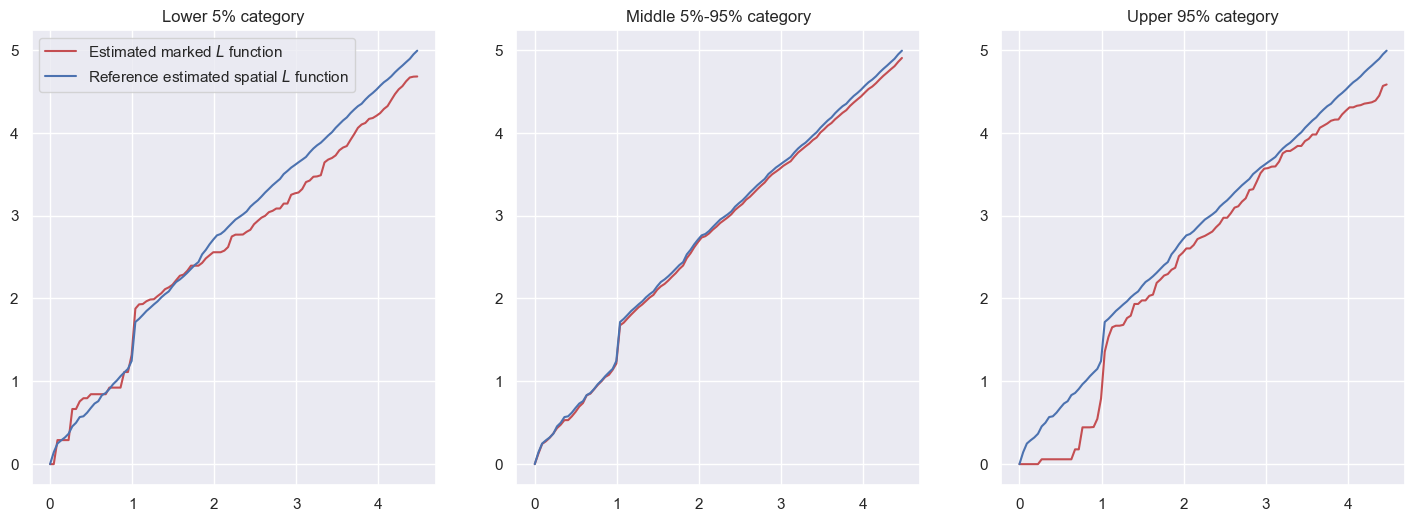

In [11]:
# Plot marked L functions
# Interpretation cannot be done as before, see print below.

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(5.90666 * 3, 5.90666 * 1))

ax.plot(r_list, np.sqrt(mK_func1 / (np.pi * mean_mark1 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax.plot(r_list, np.sqrt(K_func / (np.pi * sq_mean_intensity)), label="Reference estimated spatial $L$ function")
ax.set_title("Lower 5% category")

ax2.plot(r_list, np.sqrt(mK_func2 / (np.pi * mean_mark2 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax2.plot(r_list, np.sqrt(K_func / (np.pi * sq_mean_intensity)), label="Reference estimated spatial $L$ function")
ax2.set_title("Middle 5%-95% category")

ax3.plot(r_list, np.sqrt(mK_func3 / (np.pi * mean_mark3 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax3.plot(r_list, np.sqrt(K_func / (np.pi * sq_mean_intensity)), label="Reference estimated spatial $L$ function")
ax3.set_title("Upper 95% category")

ax.legend()

print("Expected result: Comparing results to estimated spatial $L$ function is not valid anymore, as shown for first and third graphic.")
print("For example, in the third graphic, it is expected for the red curve to be lower as we focus on points around those with higher marks, so signal is expected to be lower.")
print("When using these functions, it is better to compare using permutation tests as shown below.")

In [12]:
# Fix random seed for consistency in results. Compute 199 marked functions with randomly permuted marks.
np.random.seed(0)
marks_permut_list = [np.random.permutation(marks) for i in range(199)]

permuted_mK1 = np.array([marked_K_func(X, Y, r_list, horizon_x, horizon_y, lower_bound, upper_bound, marks_permu, marks_permu, m_func_inf)[0] for marks_permu in marks_permut_list])
permuted_mL1 = np.sqrt(permuted_mK1 / (np.pi * mean_mark1 * sq_mean_intensity))

permuted_mK2 = np.array([marked_K_func(X, Y, r_list, horizon_x, horizon_y, lower_bound, upper_bound, marks_permu, marks_permu, m_func_mid)[0] for marks_permu in marks_permut_list])
permuted_mL2 = np.sqrt(permuted_mK2 / (np.pi * mean_mark2 * sq_mean_intensity))

permuted_mK3 = np.array([marked_K_func(X, Y, r_list, horizon_x, horizon_y, lower_bound, upper_bound, marks_permu, marks_permu, m_func_sup)[0] for marks_permu in marks_permut_list])
permuted_mL3 = np.sqrt(permuted_mK3 / (np.pi * mean_mark3 * sq_mean_intensity))

In [13]:
# Compute estimated "fully random" L functions and envelopes of confidence.

estimated_L_random1 = np.mean(permuted_mL1[:100, :], axis=0)
marked_L_envelope1 = np.abs(permuted_mL1[101:, :] - estimated_L_random1[np.newaxis, :])
D_max1 = np.max(marked_L_envelope1)

estimated_L_random2 = np.mean(permuted_mL2[:100, :], axis=0)
marked_L_envelope2 = np.abs(permuted_mL2[101:, :] - estimated_L_random2[np.newaxis, :])
D_max2 = np.max(marked_L_envelope2)

estimated_L_random3 = np.mean(permuted_mL3[:100, :], axis=0)
marked_L_envelope3 = np.abs(permuted_mL3[101:, :] - estimated_L_random3[np.newaxis, :])
D_max3 = np.max(marked_L_envelope3)


In [14]:
# Computing p-values from envelopes
u0_1 = np.max(np.abs( np.sqrt(mK_func1 / (np.pi * mean_mark1 * sq_mean_intensity)) - estimated_L_random1))
ui_1 = np.max(marked_L_envelope1, axis=1)
p_value1 = 1 - np.sum(ui_1 < u0_1) / 100

u0_2 = np.max(np.abs( np.sqrt(mK_func2 / (np.pi * mean_mark2 * sq_mean_intensity)) - estimated_L_random2))
ui_2 = np.max(marked_L_envelope2, axis=1)
p_value2 = 1 - np.sum(ui_2 < u0_2) / 100

u0_3 = np.max(np.abs( np.sqrt(mK_func3 / (np.pi * mean_mark3 * sq_mean_intensity)) - estimated_L_random3))
ui_3 = np.max(marked_L_envelope3, axis=1)
p_value3 = 1 - np.sum(ui_3 < u0_3) / 100

As we can see, estimated marked L random are almost identical each time to spatial L function but the envelopes are different depending on the used mark interaction function.
This is confirmed by p-values above any traditional thresholds (0.01, 0.05), so null hypothesis is not rejected.


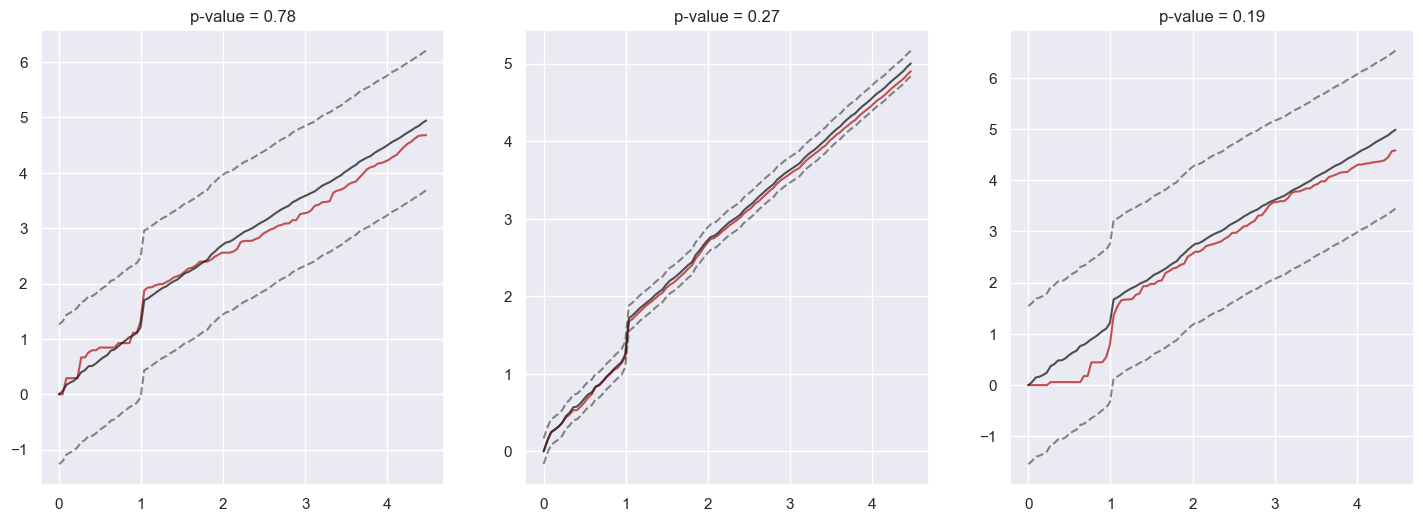

In [15]:
# Plotting curves agains estimated random envelopes and p-values as plot titles.
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(5.90666 * 3, 5.90666 * 1))

ax.plot(r_list, np.sqrt(mK_func1 / (np.pi * mean_mark1 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax.plot(r_list, estimated_L_random1, c="k", alpha=0.75, label="Estimated random $L$ function")
ax.plot(r_list, estimated_L_random1 + D_max1 , c="k", linestyle="--", alpha=0.5)
ax.plot(r_list, estimated_L_random1 - D_max1 , c="k", linestyle="--", alpha=0.5)
ax.set_title("p-value = " + str(np.round(p_value1, 3)))

ax2.plot(r_list, np.sqrt(mK_func2 / (np.pi * mean_mark2 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax2.plot(r_list, estimated_L_random2, c="k", alpha=0.75, label="Estimated random $L$ function")
ax2.plot(r_list, estimated_L_random2 + D_max2 , c="k", linestyle="--", alpha=0.5)
ax2.plot(r_list, estimated_L_random2 - D_max2 , c="k", linestyle="--", alpha=0.5)
ax2.set_title("p-value = " + str(np.round(p_value2, 3)))

ax3.plot(r_list, np.sqrt(mK_func3 / (np.pi * mean_mark3 * sq_mean_intensity)), c="r", label="Estimated marked $L$ function")
ax3.plot(r_list, estimated_L_random3, c="k", alpha=0.75, label="Estimated random $L$ function")
ax3.plot(r_list, estimated_L_random3 + D_max3 , c="k", linestyle="--", alpha=0.5)
ax3.plot(r_list, estimated_L_random3 - D_max3 , c="k", linestyle="--", alpha=0.5)
ax3.set_title("p-value = " + str(np.round(p_value3, 3)))

print("As we can see, estimated marked L random are almost identical each time to spatial L function but the envelopes are different depending on the used mark interaction function.")
print("This is confirmed by p-values above any traditional thresholds (0.01, 0.05), so null hypothesis is not rejected.")

Although the curves deviate from 0.0 (completely random marks), no curve is outside the confidence envelopes, confirming that the marks do not appear correlated to the spatial structure of the process
This is confirmed by p-values above any traditional thresholds (0.01, 0.05), so null hypothesis is not rejected.


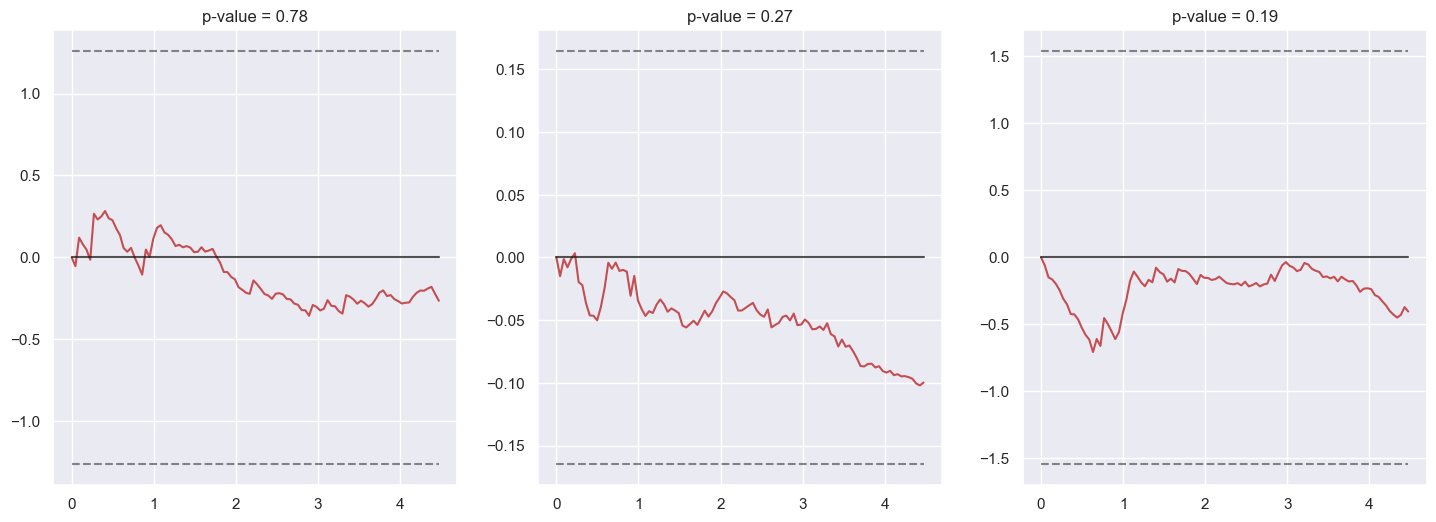

In [16]:
# For better visibility, plot deviation from random model by comparing to estimated_L_random versions

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(5.90666 * 3, 5.90666 * 1))

ax.plot(r_list, np.sqrt(mK_func1 / (np.pi * mean_mark1 * sq_mean_intensity)) - estimated_L_random1, c="r", label="Estimated marked $L$ function")
ax.plot(r_list, np.zeros(r_list.shape), c="k", alpha=0.75, label="Estimated random $L$ function")
ax.plot(r_list, D_max1 * np.ones(r_list.shape) , c="k", linestyle="--", alpha=0.5)
ax.plot(r_list, - D_max1 * np.ones(r_list.shape) , c="k", linestyle="--", alpha=0.5)
ax.set_title("p-value = " + str(np.round(p_value1, 3)))

ax2.plot(r_list, np.sqrt(mK_func2 / (np.pi * mean_mark2 * sq_mean_intensity)) - estimated_L_random2, c="r", label="Estimated marked $L$ function")
ax2.plot(r_list, np.zeros(r_list.shape), c="k", alpha=0.75, label="Estimated random $L$ function")
ax2.plot(r_list, D_max2 * np.ones(r_list.shape), c="k", linestyle="--", alpha=0.5)
ax2.plot(r_list, -D_max2 * np.ones(r_list.shape), c="k", linestyle="--", alpha=0.5)
ax2.set_title("p-value = " + str(np.round(p_value2, 3)))


ax3.plot(r_list, np.sqrt(mK_func3 / (np.pi * mean_mark3 * sq_mean_intensity)) - estimated_L_random3, c="r", label="Estimated marked $L$ function")
ax3.plot(r_list, np.zeros(r_list.shape), c="k", alpha=0.75, label="Estimated random $L$ function")
ax3.plot(r_list, D_max3 * np.ones(r_list.shape), c="k", linestyle="--", alpha=0.5)
ax3.plot(r_list, -D_max3 * np.ones(r_list.shape), c="k", linestyle="--", alpha=0.5)
ax3.set_title("p-value = " + str(np.round(p_value3, 3)))


print("Although the curves deviate from 0.0 (completely random marks), no curve is outside the confidence envelopes, confirming that the marks do not appear correlated to the spatial structure of the process")
print("This is confirmed by p-values above any traditional thresholds (0.01, 0.05), so null hypothesis is not rejected.")

In [17]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 3.79 seconds
